In [1]:
import torch
import cv2
import copy
import matplotlib.pyplot as plt
from engine.predictor import DefaultPredictor

from  config.config import get_cfg
from model.rcnn import GeneralizedRCNN
from engine.optimizer import build_optimizer,build_lr_scheduler

from data.build import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from data.mapper import DatasetMapper
import data.transforms as T
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
from structures.image_list import ImageList
from engine.detection_checkpointer import DetectionCheckpointer
from data.utils import build_augmentation

from model.ssl_score.preprocess import preprocess,open_candidate
from model.ssl_score.dino_score import cosine_distance_torch


/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.device_count())
torch.cuda.set_device(0)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('./config_files/voc.yaml')
cfg.MODEL.SAVE_IDX=10
cfg.MODEL.RPN.USE_MDN=False
cfg.log = False 
cfg.MODEL.ROI_HEADS.USE_MLN = True
cfg.MODEL.ROI_HEADS.AUTO_LABEL = False
cfg.MODEL.ROI_HEADS.AF = 'baseline'
cfg.MODEL.RPN.AUTO_LABEL = False
cfg.MODEL.ROI_BOX_HEAD.USE_FD = False
cfg.MODEL.RPN.AUTO_LABEL_TYPE = 'sum'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.INPUT.RANDOM_FLIP = "none"


# cfg.merge_from_list(args.opts)
RPN_NAME = 'mdn' if cfg.MODEL.RPN.USE_MDN else 'base'
ROI_NAME = 'mln' if cfg.MODEL.ROI_HEADS.USE_MLN else 'base'
MODEL_NAME = RPN_NAME + ROI_NAME
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

2
0


In [3]:
DIR_NAME = '/data/jeongeun/OWOD_datasets/VOC2007'
split = 'test'
data = load_voc_instances(DIR_NAME,split,VOC_CLASS_NAMES,phase=None,COCO_CLASS=True)
print(len(data))
mapper = DatasetMapper(is_train=True, augmentations=build_augmentation(cfg,True))
data_loader = build_detection_train_loader(data,mapper=mapper,total_batch_size=1)
IDX = 5000
VOC_CLASS_NAMES_NEW = (*VOC_CLASS_NAMES, 'unknown')

10246


In [5]:
model = GeneralizedRCNN(cfg).to('cuda')
state_dict = torch.load('./ckpt/{}/{}_{}_15000.pt'.format(cfg.MODEL.ROI_HEADS.AF,cfg.MODEL.SAVE_IDX,MODEL_NAME),map_location='cuda')
pretrained_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(pretrained_dict)

predictor = DefaultPredictor(cfg,model)

device_vit = 'cuda:1'
referenec_set = open_candidate()[0].to('cuda')
vit = torch.hub.load('facebookresearch/dino:main', 'dino_vits8').to(device_vit)


Using cache found in /home/jeongeun/.cache/torch/hub/facebookresearch_dino_main


[Instances(num_instances=100, image_height=800, image_width=800, fields=[pred_boxes: Boxes(tensor([[2.6818e+02, 4.4430e+02, 3.6714e+02, 5.4016e+02],
        [7.4711e+01, 4.8563e+02, 2.3256e+02, 6.0004e+02],
        [8.0479e+01, 4.7391e+02, 7.6867e+02, 7.9322e+02],
        [5.7910e+02, 4.2247e+02, 7.1885e+02, 4.9417e+02],
        [5.0070e+02, 5.6344e+02, 7.4934e+02, 7.9600e+02],
        [5.7651e+02, 5.1221e+02, 7.8802e+02, 7.8581e+02],
        [4.5919e+02, 6.5685e+02, 6.1287e+02, 8.0000e+02],
        [2.6661e+01, 5.2498e+02, 5.2151e+02, 7.8994e+02],
        [4.7880e-01, 4.7338e+02, 7.0882e+01, 6.4199e+02],
        [1.6686e+02, 2.7955e+02, 1.8941e+02, 3.3982e+02],
        [2.6256e+01, 3.5267e+02, 1.4887e+02, 4.7459e+02],
        [4.4278e+02, 4.1145e+02, 7.2718e+02, 7.9435e+02],
        [5.0293e+02, 2.2376e+02, 5.6841e+02, 3.1610e+02],
        [2.1068e+02, 3.7592e+01, 2.4786e+02, 9.5420e+01],
        [2.1847e+02, 3.1453e+01, 2.5404e+02, 8.0407e+01],
        [9.9652e+01, 3.0001e+02, 3.0185

RuntimeError: CUDA out of memory. Tried to allocate 1.29 GiB (GPU 1; 23.70 GiB total capacity; 21.69 GiB already allocated; 111.56 MiB free; 21.96 GiB reserved in total by PyTorch)

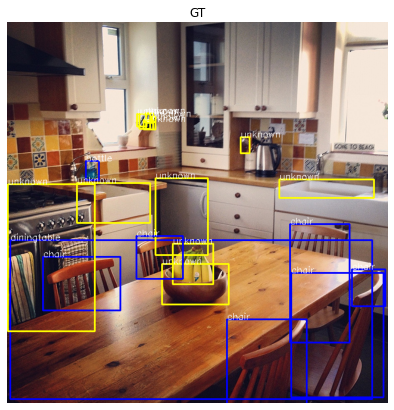

In [8]:

batched_inputs = data.__getitem__(IDX)
gts = batched_inputs['annotations']
gt_bboxs = [a['bbox'] for a in gts]
gt_cls = [a['category_id'] for a in gts]
file_name = batched_inputs['file_name']
img = cv2.imread(file_name)

pred = predictor(img)
pred = pred['instances']._fields
IDX +=10

demo_image = copy.deepcopy(img)
for bbox,label in zip(gt_bboxs,gt_cls):
    if label==20:
        color = (0,255,255)
    else:
        color = (255,0,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), color, 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES_NEW[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
plt.title("GT")
plt.imshow(demo_image)
plt.axis('off')

pred_boxes = pred['pred_boxes']
scores = pred['scores']
pred_classes = pred['pred_classes']

index = torch.where(scores>0.3)[0]
pred_boxes = pred_boxes[index]
pred_classes = pred_classes[index]
scores = scores[index]

tf_image = torch.tensor(img.transpose(2,0,1))
patches = preprocess(tf_image,pred_boxes.tensor,None)

ref_feat = open_candidate()[0].to('cuda')
feat = vit(patches.to(device_vit)).detach().to('cuda')
cos_sim = cosine_distance_torch(referenec_set,feat)
# print(cos_sim)
demo_image = copy.deepcopy(img)
for bbox,label,sc in zip(pred_boxes,pred_classes,cos_sim):
    # print(label)
    if sc<0.4 or label == 20:
        color = (0,255,255)
        label = 20
    else:
        color = (255,0,0)
    # color = (255,0,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), color, 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES_NEW[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    # cv2.putText(demo_image, str(sc.item()), 
    #                         (int(bbox[0]), int(bbox[1])),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.subplot(1,2,2)
plt.title("Predicted")
plt.imshow(demo_image)
plt.axis('off')
plt.savefig('./dummy/roi_head/mdn_1_{}.png'.format(IDX))
plt.show()
